In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = CliffWalkingEnv()

In [3]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            
            # state_one_hot will be an 1-d array of size n, with
            # the element on the index specified by self.state assigned
            # the value of 1
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))

            # output_layer will pump out weights for each action
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer
            )

            # tf.nn.softmax() will give (1, 4) output.
            # 'Squeeze' that output into an 1-d array.
            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            
            # We just need to know the probability assigned to the chosen action.
            self.picked_action_prob = tf.gather(self.action_probs, self.action)

            # Loss and train op
            self.loss = -tf.log(self.picked_action_prob) * self.target

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

            self.train_op = self.optimizer.minimize(
                self.loss,
                global_step=tf.contrib.framework.get_global_step()
            )
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        
        return sess.run(self.action_probs, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()

        feed_dict = { 
            self.state: state,
            self.target: target,
            self.action: action
        }

        _, loss = sess.run(
            [self.train_op, self.loss],
            feed_dict
        )

        return loss

In [4]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer
            )

            self.value_estimate = tf.squeeze(self.output_layer)

            # TD Error?
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            
            self.train_op = self.optimizer.minimize(
                self.loss,
                global_step=tf.contrib.framework.get_global_step()
            )        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()

        feed_dict = {
            self.state: state,
            self.target: target
        }

        _, loss = sess.run(
            [self.train_op, self.loss],
            feed_dict
        )

        return loss

In [5]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the first action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(
                Transition(
                    state=state, action=action, reward=reward, next_state=next_state, done=done
                )
            )
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TODO: Calculate TD Target
            td_target = reward + discount_factor * estimator_value.predict(next_state)
            td_error = td_target - estimator_value.predict(state)
            
            # TODO: Update the value estimator
            estimator_value.update(
                state=state,
                # estimator_value will calculate TD Error internally
                # with td_target given
                target=td_target
            )
            
            # TODO: Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(
                state=state,
                target=td_error,
                action=action
            )

            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [6]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~300 seemed to work well for me.
    stats = actor_critic(env, policy_estimator, value_estimator, 300)

Step 12 @ Episode 300/300 (-13.0)))

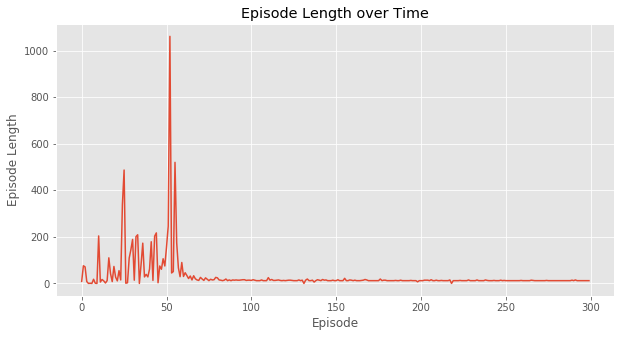

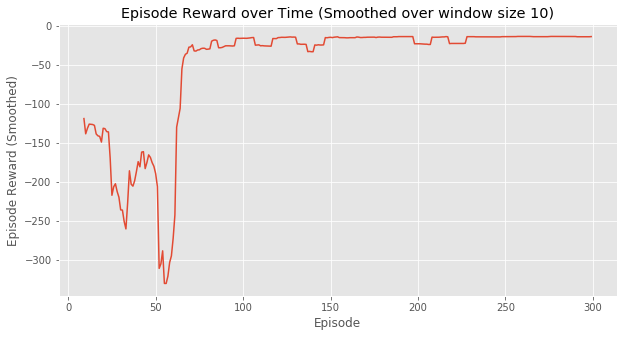

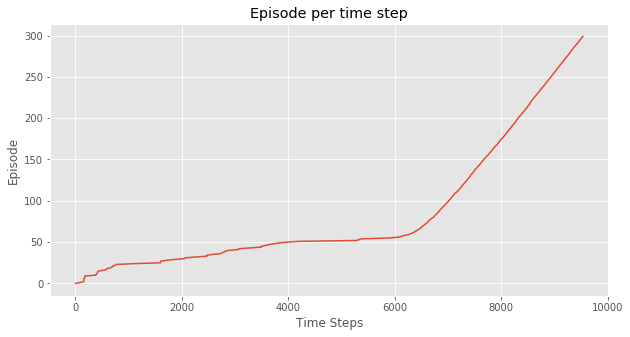

(<matplotlib.figure.Figure at 0x11552fac8>,
 <matplotlib.figure.Figure at 0x1181f0400>)

In [7]:
plotting.plot_episode_stats(stats, smoothing_window=10)